In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("/home/simonpf/src/joint_flight/misc/matplotlib_style.rc")

In [2]:
%pwd

'/home/simonpf/src/lic/notebooks'

In [3]:
from datetime import datetime
import cloud_colocations
from cloud_colocations.colocations.products import set_cache
from cloud_colocations.colocations.formats import ModisCombined, DardarCloud, TWOBCLDCLASS, GPMGMI1C
set_cache("../data")

#t = datetime(2014, 3, 9, 1, 33)
#modis = ModisCombined.get_by_date(t)
#gpm = GPMGMI1C.get_by_date(t)
#dardar = DardarCloud.get_by_date(t)


Using login:  juliakukulies Strolchi1!


In [4]:
modis = ModisCombined("../data/MYD021KM.A2014068.0130.006.2014068155655.hdf",
                      "../data/MYD03.A2014068.0130.006.2014068151346.hdf")
gpm = GPMGMI1C("../data/1C-R.GPM.GMI.XCAL2016-C.20140309-S011445-E024711.000146.V05A.HDF5")
dardar = DardarCloud("../data/DARDAR-CLOUD_v2.1.1_2014068005444_41824.hdf")

In [5]:
%ls ../data

1C-R.GPM.GMI.XCAL2016-C.20140309-S011445-E024711.000146.V05A.HDF5
DARDAR-CLOUD_v2.1.1_2014068005444_41824.hdf
MYD021KM.A2014068.0130.006.2014068155655.hdf
MYD021KM.A2015068.0135.006.2015068183324.hdf
MYD03.A2014068.0130.006.2014068151346.hdf
MYD03.A2014068.0135.006.2014068151856.hdf
MYD03.A2015068.0135.006.2015068182404.hdf


## Define region of interest

In [6]:
lat_1 = -22
lat_0 = -28
lon_1 = -172
lon_0 = -178
center = np.array([0.5 * (lon_1 + lon_0), 0.5 * (lat_0 + lat_1)])

## Dardar

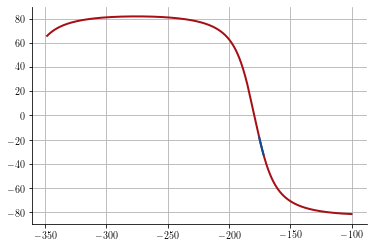

In [8]:
from geopy import distance
lats = dardar.get_latitudes()
lons = dardar.get_longitudes()
lons[lons > 0.0] -= 360
i_start, i_end = np.where(np.logical_and(lats > lat_0 - 4, lats <= lat_1 + 4))[0][[0, -1]]
plt.plot(lons, lats)
plt.plot(lons[i_start : i_end], lats[i_start : i_end])

lats_dardar = lats[i_start : i_end]
lons_dardar = lons[i_start : i_end]
x_dardar = np.zeros(i_end - i_start)
y_dardar = np.zeros(i_end - i_start)
for i in range(x_dardar.size):
    # c = [lat, lon]
    c = np.array([center[1], lons_dardar[i]])
    x_dardar[i] = np.sign(c[1] - center[0]) * distance.geodesic(c, center[::-1]).km
    c = np.array([lats_dardar[i], center[0]])
    y_dardar[i] = np.sign(c[0] - center[1]) * distance.geodesic(c, center[::-1]).km

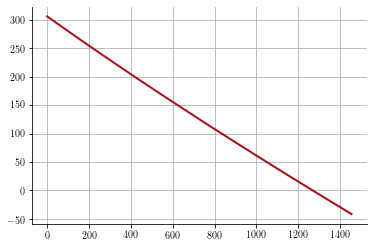

In [9]:
plt.plot(x_dardar)

In [10]:
lats_dardar = lats[i_start : i_end]
lons_dardar = lons[i_start : i_end]
rr = dardar.get_radar_reflectivity()[i_start : i_end, :]
lb = dardar.get_lidar_backscatter()[i_start : i_end, :]
z = dardar.get_altitude()

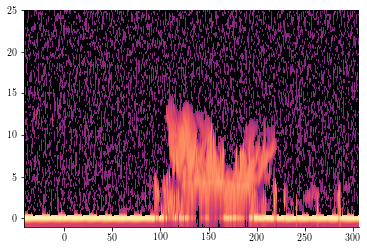

In [11]:
from matplotlib.colors import LogNorm
plt.pcolormesh(x_dardar, z / 1e3, np.maximum(rr.T, 1e-8), norm = LogNorm())

In [12]:
%rm dardar.nc

In [13]:
from netCDF4 import Dataset
file = Dataset("dardar.nc", "w")
file.createDimension("along_track", lats_dardar.shape[0])
file.createDimension("z", z.size)
file.createDimension("dims", 3)
file.createVariable("z", "f4", dimensions = ("along_track", "z",))
file.createVariable("latitude", "f4", dimensions = ("along_track", "z"))
file.createVariable("longitude", "f4", dimensions = ("along_track", "z"))
file.createVariable("rr", "f4", dimensions = ("along_track", "z"))
file.createVariable("lb", "f4", dimensions = ("along_track", "z"))
file.createVariable("loc", "f4", dimensions = ("along_track", "z", "dims"))

file["z"][:] = np.broadcast_to(z[np.newaxis, :], rr.shape)
file["latitude"][:] = np.broadcast_to(lats_dardar[:, np.newaxis], rr.shape)
file["longitude"][:] = np.broadcast_to(lons_dardar[:, np.newaxis], rr.shape)
file["rr"][:] = rr
file["lb"][:] = lb
file["loc"][:, :, 0] = file["longitude"][:]
file["loc"][:, :, 1] = file["latitude"][:]
file["loc"][:, :, 2] = file["z"][:]

file.close()

## Modis data

In [14]:
lats = modis.geo_file.lats
lons = modis.geo_file.lons
i_start, i_end = np.where(np.logical_and(lats > lat_0, lats <= lat_1))[0][[0, -1]]
lats_modis = modis.geo_file.lats[i_start : i_end, :]
lons_modis = modis.geo_file.lons[i_start : i_end, :]
lons_modis[lons_modis >= 0] -= 360

In [15]:
from skimage import exposure
modis_rgb = np.copy(np.transpose(modis.data[[0, 3, 2], i_start : i_end, :], [1, 2, 0]))
for i in range(3):
    x_min = np.nanmin(modis_rgb[:, :, i])
    x_max = np.nanmax(modis_rgb[:, :, i])
    modis_rgb[:, :, i] = (modis_rgb[:, :, i] - x_min) / (x_max - x_min)
    modis_rgb[:, :, i] = exposure.equalize_adapthist(modis_rgb[:, :, i], clip_limit=0.03)

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [16]:
from tqdm.auto import tqdm
x_modis = np.zeros((i_end - i_start, lats_modis.shape[1]))
y_modis = np.zeros((i_end - i_start, lats_modis.shape[1]))
for i in tqdm(range(x_modis.shape[0])):
    for j in range(x_modis.shape[1]):
        c = np.array([center[1], lons_modis[i, j]])
        x_modis[i, j] = np.sign(c[1] - center[0]) * distance.geodesic(c, center[::-1]).km
        c = np.array([lats_modis[i, j], center[0]])
        y_modis[i, j] = np.sign(c[0] - center[1]) * distance.geodesic(c, center[::-1]).km

In [17]:
from netCDF4 import Dataset
file = Dataset("modis.nc", "w")
file.createDimension("along_track", lats_modis.shape[0])
file.createDimension("across_track", lats_modis.shape[1])
file.createDimension("channels", 3)
file.createVariable("latitude", "f4", dimensions = ("along_track", "across_track"))
file.createVariable("longitude", "f4", dimensions = ("along_track", "across_track"))
file.createVariable("true_color", "f4", dimensions = ("along_track", "across_track", "channels"))

file["latitude"][:] = lats_modis
file["longitude"][:] = lons_modis
file["true_color"][:] = modis_rgb
file.close()

## GPM data

In [18]:
lats = gpm.lat_s1[:]
lons = gpm.lon_s1[:]
lons[lons >= 0.0] -= 360
i_start, i_end = np.where(np.logical_and(lons > lon_0, lons <= lon_1))[0][[0, -1]]
#i_end = i_start + 500

tbs_gpm = np.zeros((i_end - i_start, lats.shape[1], 13))
lats_gpm = gpm.lat_s1[i_start : i_end, :]
lons_gpm = gpm.lon_s1[i_start : i_end, :]
lons_gpm[lons_gpm >= 0.0] -= 360
tbs_gpm[:, :, :9] = gpm.y_s1[i_start : i_end, :, :]
tbs_gpm[:, :, 9:] = gpm.y_s2[i_start : i_end, :, :]


In [19]:
from tqdm.auto import tqdm
x_gpm = np.zeros((i_end - i_start, lats_gpm.shape[1]))
y_gpm = np.zeros((i_end - i_start, lats_gpm.shape[1]))
for i in tqdm(range(x_gpm.shape[0])):
    for j in range(x_gpm.shape[1]):
        c = np.array([center[1], lons_gpm[i, j]])
        x_gpm[i, j] = np.sign(c[1] - center[0]) * distance.geodesic(c, center[::-1]).km
        c = np.array([lats_gpm[i, j], center[0]])
        y_gpm[i, j] = np.sign(c[0] - center[1]) * distance.geodesic(c, center[::-1]).km

In [20]:
%rm gpm.nc

In [21]:
from netCDF4 import Dataset
file = Dataset("gpm.nc", "w")
file.createDimension("along_track", lats_gpm.shape[0])
file.createDimension("across_track", lats_gpm.shape[1])
file.createDimension("channels", 13)
file.createVariable("latitude", "f4", dimensions = ("along_track", "across_track"))
file.createVariable("longitude", "f4", dimensions = ("along_track", "across_track"))
file.createVariable("tbs", "f4", dimensions = ("along_track", "across_track", "channels"))

file["latitude"][:] = lats_gpm
file["longitude"][:] = lons_gpm
file["tbs"][:] = tbs_gpm
file.close()

## Putting it together

In [100]:
rr.shape

(1455, 436)

In [105]:
y_modis.shape

(1022, 1354)

In [103]:
import pyvista as pv
from matplotlib.colors import Normalize
from matplotlib.cm import magma
from cloud_colocations.plots import grid_to_edges


i_start = np.where(y_dardar > y_modis.min())[0][0]
i_end = np.where(y_dardar > y_modis.max())[0][-1]
rrr = rr[i_start : i_end, :]
xx = grid_to_edges(np.broadcast_to(x_dardar[i_start: i_end, np.newaxis], rrr.shape))
yy = grid_to_edges(np.broadcast_to(y_dardar[i_start: i_end, np.newaxis], rrr.shape))
zz = grid_to_edges(np.broadcast_to(z[np.newaxis, :], rrr.shape)) / 1e2
vertices = np.zeros((xx.size, 3))
vertices[:, 0] = xx.ravel()
vertices[:, 1] = yy.ravel()
vertices[:, 2] = zz.ravel()
dardar_curtain = pv.StructuredGrid(xx, yy, zz)
dbz =  np.minimum(10.0 * np.log10(np.maximum(rrr[:, :], 1e-3)).T, 20)
dardar_curtain.cell_arrays["radar_reflectivity"] = dbz.ravel()
dardar_curtain.save("dardar.vts")

In [107]:
y_modis

array([[-332.26625111, -333.56491745, -334.85132642, ..., -715.20427238,
        -715.46693264, -715.72917004],
       [-330.30916681, -331.61353683, -332.90586091, ..., -713.18737474,
        -713.44368982, -713.69979351],
       [-328.35145343, -329.66173848, -330.95997763, ..., -711.17048284,
        -711.42045277, -711.67021131],
       ...,
       [ 633.69976954,  632.63374974,  631.57744103, ...,  279.98726613,
         279.60412479,  279.21950478],
       [ 635.6694435 ,  634.597514  ,  633.53529557, ...,  281.9889341 ,
         281.61213001,  281.23384726],
       [ 637.6395359 ,  636.5614856 ,  635.49335746, ...,  283.99059759,
         283.6199195 ,  283.24797399]])

In [64]:
j_start, j_end = 350, 700
xx = grid_to_edges(x_modis[:, j_start : j_end])
yy = grid_to_edges(y_modis[:, j_start : j_end])
zz = grid_to_edges(np.zeros(x_modis[:, j_start : j_end].shape))
vertices = np.zeros((xx.size, 3))
vertices[:, 0] = xx.ravel()
vertices[:, 1] = yy.ravel()
vertices[:, 2] = zz.ravel()
modis_surface = pv.StructuredGrid(xx, yy, zz)
modis_surface.texture_map_to_plane(inplace = True)
modis_texture = pv.numpy_to_texture(np.array(256 * modis_rgb, dtype = np.uint8, order = "F"))
modis_surface.save("modis.vts")

In [65]:
i_start, i_end = 70, -100
j_start, j_end = 75, -75
xx = grid_to_edges(x_gpm[i_start : i_end, j_start : j_end])
yy = grid_to_edges(y_gpm[i_start : i_end, j_start : j_end])
zz = grid_to_edges(np.ones(x_gpm[i_start : i_end, j_start : j_end].shape))
vertices = np.ones((xx.size, 3))
vertices[:, 0] = xx.ravel()
vertices[:, 1] = yy.ravel()
vertices[:, 2] = zz.ravel()
gpm_surface = pv.StructuredGrid(xx, yy, zz)
for i in range(13):
    gpm_surface.cell_arrays["tbs_{}".format(i)] = np.array(tbs_gpm[i_start : i_end, j_start:j_end, i].T.ravel(), order = "F")
gpm_surface.save("gpm.vts")

In [71]:
plotter.camera_position

[(2022.9288311844853, 1884.5927795558046, 2005.4886316145744),
 (137.74019956991071, -0.5958520587698786, 120.3),
 (0.0, 0.0, 1.0)]

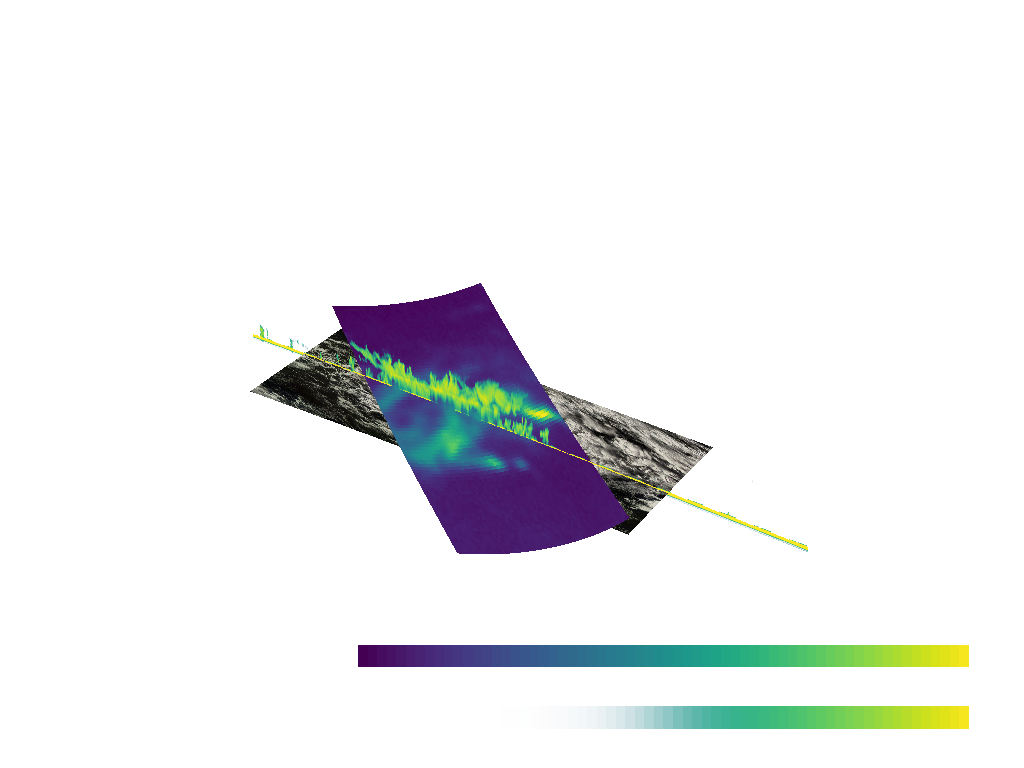

In [110]:
plotter = pv.Plotter()
cp = plotter.camera_position
#plotter.camera_posistion = [(c[0] / 2.0, c[1] / 2.0, c[2] / 2.0) for c in cp]
#cp_new = plotter.camera_posistion
plotter.background_color = "white"
plotter.add_mesh(modis_surface, texture = modis_texture)
plotter.add_mesh(dardar_curtain, lighting = False, opacity = "sigmoid")
plotter.add_mesh(gpm_surface, lighting = False, lightning = False)
plotter.show()